# Incremental

In this notebook, we will apply different anomaly detection methods for incremental data, i.e., data that is received in a stream.

---

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [126]:
data_path = "./data/sensor.csv"
df = pd.read_csv(data_path, index_col=0)

## Preprocessing

First, we preprocess the data applying all the transformations decided and explained in the EDA notebook (see `eda.ipynb`).  
We will use the same transformations for both the incremental and non-incremental approaches.

In [127]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Remove duplicates
df = df.drop_duplicates()

# Remove redundant features
df = df.drop(columns=['sensor_15'])

# Impute missing values with mean for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Apply PCA
X = df.drop(['machine_status'], axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the original index to the PCA DataFrame
pca_df.index = df.index

# Add the machine status to the PCA DataFrame
pca_df['machine_status'] = df['machine_status'].values

pca_df

,PC1,PC2,machine_status
timestamp,,,
2018-04-01 00:00:00,0.010524,0.776836,NORMAL
2018-04-01 00:01:00,0.010524,0.776836,NORMAL
2018-04-01 00:02:00,0.151425,0.782444,NORMAL
2018-04-01 00:03:00,0.151886,0.816479,NORMAL
2018-04-01 00:04:00,0.106250,0.929110,NORMAL
...,...,...,...
2018-08-31 23:55:00,2.014969,2.388225,NORMAL
2018-08-31 23:56:00,2.014980,2.404067,NORMAL
2018-08-31 23:57:00,2.028597,2.399141,NORMAL


## Interquartile Range (IQR)

First, the IQR method is used to detect anomalies in the PCA-transformed data.   

We iterate through the data row by row, simulating a stream of data.   
Then we update the IQR for each column (`PC1` and `PC2`) of the new data point and check if it falls outside the bounds.

Note that we assume as pump anomaly any data point where one of the two PCA components is an anomaly.

In [128]:
from river import stats

class IQR_Outlier_Detector:
    def __init__(self, factor=1.5):
        self.q1 = stats.Quantile(0.25)  
        self.q3 = stats.Quantile(0.75)  
        self.factor = factor

    def update(self, value):
        self.q1.update(value)
        self.q3.update(value)

    def is_outlier(self, value):
        iqr = self.q3.get() - self.q1.get()
        lower_bound = self.q1.get() - self.factor * iqr
        upper_bound = self.q3.get() + self.factor * iqr

        return value < lower_bound or value > upper_bound

pc1_detector = IQR_Outlier_Detector()
pc2_detector = IQR_Outlier_Detector()

anomalies = {
    'PC1': 0,
    'PC2': 0
}

pca_df['anomaly'] = False
    
for _, row in pca_df.iterrows():
    for col in ['PC1', 'PC2']:
        value = row[col]
        if col == 'PC1':
            pc1_detector.update(value)
            if pc1_detector.is_outlier(value):
                anomalies['PC1'] += 1
                pca_df.loc[row.name, 'anomaly'] = True
        else:
            pc2_detector.update(value)
            if pc2_detector.is_outlier(value):
                anomalies['PC2'] += 1
                pca_df.loc[row.name, 'anomaly'] = True

print(f"Anomalies detected in PC1: {anomalies['PC1']}")
print(f"Anomalies detected in PC2: {anomalies['PC2']}")
print(f"Total anomalies detected: {anomalies['PC1'] + anomalies['PC2']}")
print(f"Total pump anomalies: {pca_df['anomaly'].sum()}")
print(f"Percentage of pump anomalies: {pca_df['anomaly'].sum() / len(pca_df) * 100:.2f}%")

Anomalies detected in PC1: 32148
Anomalies detected in PC2: 18687
Total anomalies detected: 50835
Total pump anomalies: 49841
Percentage of pump anomalies: 22.62%


Once obtained the anomalies in the data, let's visualize a sensor readings (`sensor_00`) with anomalies highlighted in red and machine breakdowns marked with black crosses.   
This graph provides insights into the correlation between anomalies and machine failures.

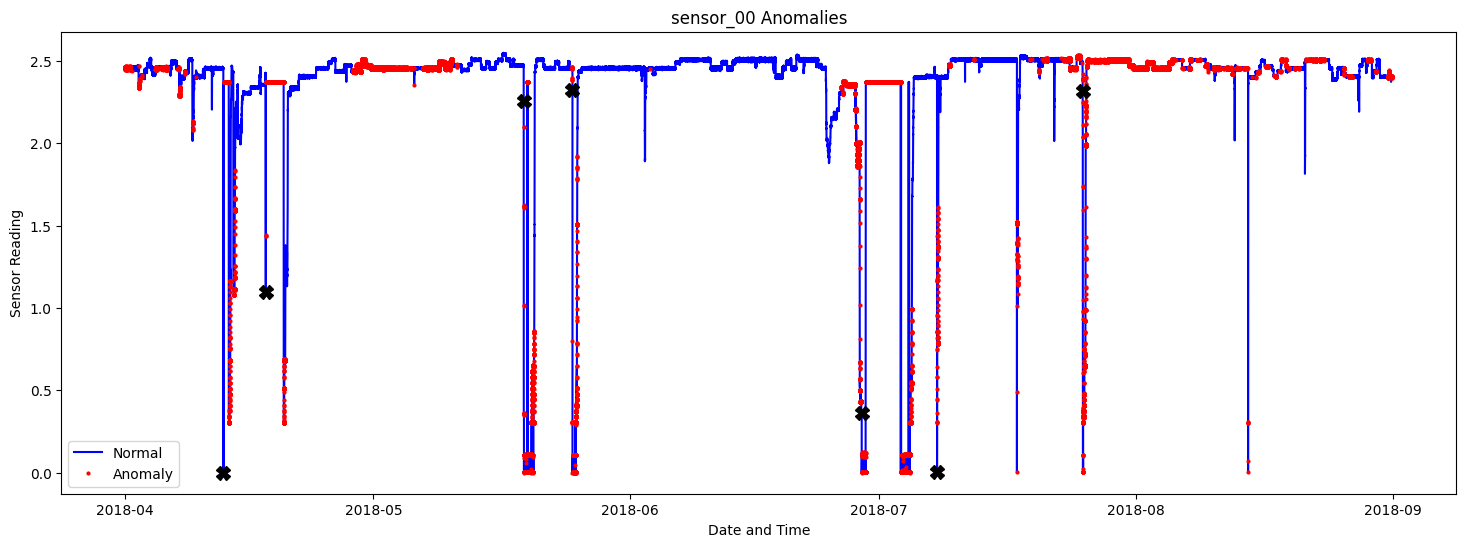

In [129]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[sensor], color='blue', label='Normal')
_ = plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
_ = plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'{sensor} Anomalies')
_ = plt.legend(loc='best')
plt.show()

Also, in the following plot, it is shown the machine status over time, with anomalies marked in red, helping to identify patterns in machine behavior.

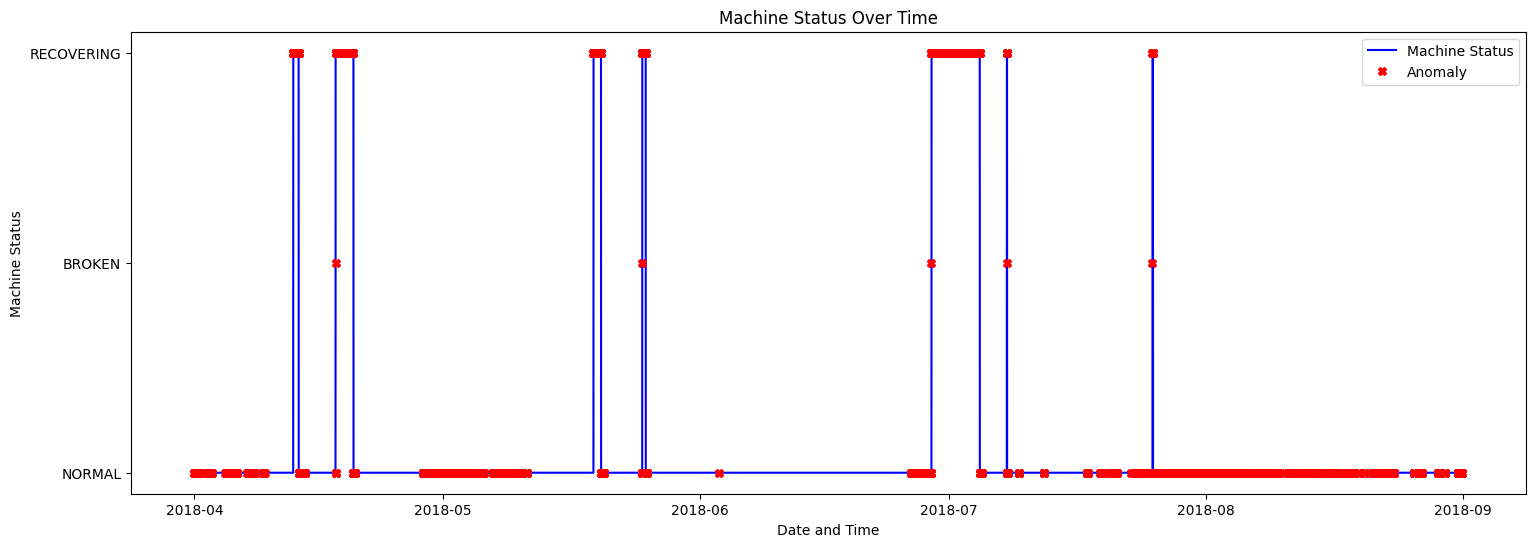

In [130]:
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
_ = plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Machine Status')
_ = plt.title('Machine Status Over Time')
_ = plt.legend(loc='best')
plt.show()

Unlike non-incremental IQR, in this case we see that at the beginning of the data stream there are a lot of anomalies, which are not present in the non-incremental IQR.   
This is because at the beginning of the data stream, the IQR is not well defined, and therefore it is not possible to determine if a point is an anomaly or not, due to the lack of data.

This also explain why the number of anomalies detected is higher than in the non-incremental case.


In [131]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Create a DataFrame with the number of anomalies for each method
anomaly_counts = {
    'Method': ['IQR', 'K-Means', 'HST'],
    'Normal': [len(df) - num_anomalies, 0, 0],
    'Anomalies': [num_anomalies, 0, 0],
    'Percentage': [percentage_anomalies, 0, 0]
}

anomaly_df = pd.DataFrame(anomaly_counts)

# Round the percentage to 2 decimal places
anomaly_df['Percentage'] = anomaly_df['Percentage'].round(2)
anomaly_df

Number of anomalies detected: 49841
Percentage of anomalies detected: 22.62%


,Method,Normal,Anomalies,Percentage
0,IQR,170479,49841,22.62
1,K-Means,0,0,0.00
2,HST,0,0,0.00


Finally, we summarize the anomalies detected by the IQR method, providing a count of the number of anomalies detected.
- Number of anomalies detected: 45,933
- Percentage of anomalies: 20.85%

## K-Means Clustering

K-means clustering with data streams is an adaptation of the traditional k-means algorithm designed to handle continuous, real-time data.

As each new data point arrives from the stream, it is immediately assigned to the nearest existing cluster based on a distance metric. Then, the centroid of that cluster is updated incrementally to reflect the inclusion of the new point, by shifting the centroid slightly toward the new data.   
This allows the algorithm to dynamically adjust to new patterns in the data without needing to store or reprocess the entire dataset.

In [132]:
from river import cluster
import math

# Reset the anomaly column
pca_df['anomaly'] = False

# Initialize K-Means with 2 clusters (for normal and anomalous data)
kmeans = cluster.KMeans(n_clusters=2, seed=42)

# Threshold to consider a point as an anomaly based on the distance to the centroid
threshold = 0.25

anomalies_detected = 0

# Euclidean distance function
def euclidean_distance(point, center):
    return math.sqrt(sum((point[feature] - center[feature]) ** 2 for feature in point))

# Simulate streaming data
for _, row in pca_df.iterrows():
    # Select features excluding the target variable
    features = row.drop(labels=['machine_status', 'anomaly']).to_dict()

    # Predict the nearest cluster
    cluster_id = kmeans.predict_one(features)

    # Get current cluster centroids
    centroids = kmeans.centers

    if centroids:
        # Get the centroid of the predicted cluster
        centroid = centroids[cluster_id]

        # Get the distance to the centroid
        distance_to_centroid = euclidean_distance(features, centroid)

        # If the distance to the centroid is greater than the threshold, mark as anomaly
        if distance_to_centroid > threshold:
            anomalies_detected += 1
            pca_df.loc[row.name, 'anomaly'] = True

    # Update the K-Means model with the new data point
    kmeans.learn_one(features)

print(f"Number of anomalies detected using K-Means: {anomalies_detected}")

Number of anomalies detected using K-Means: 10871


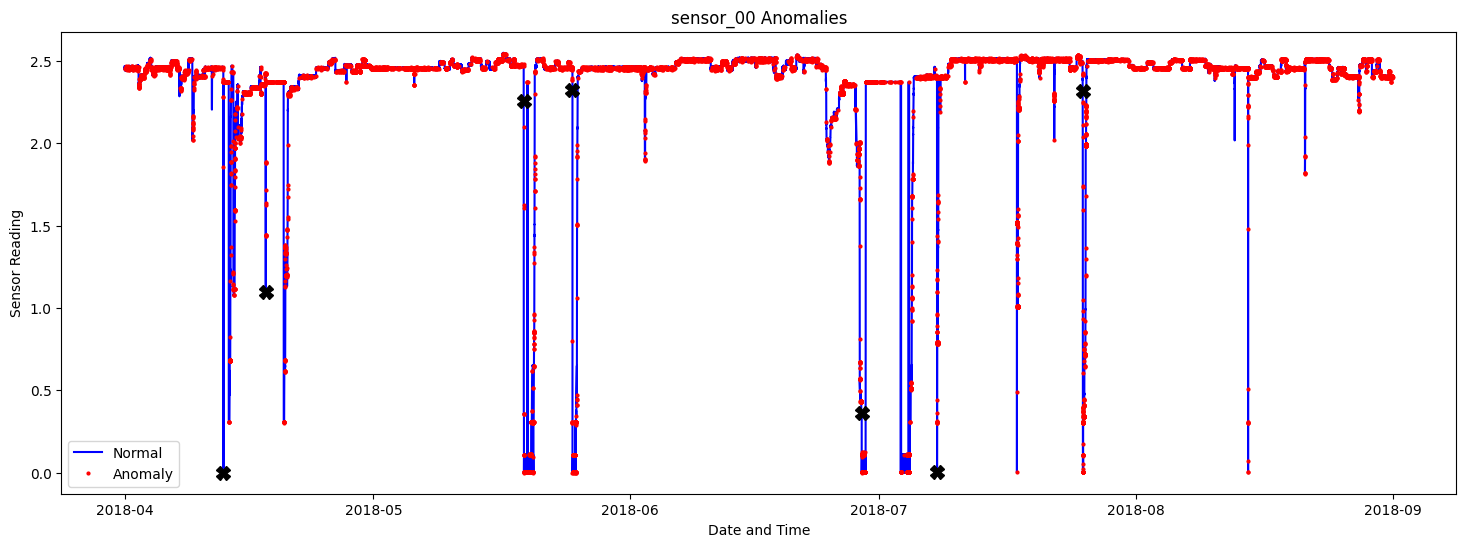

In [133]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[sensor], color='blue', label='Normal')
_ = plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
_ = plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'{sensor} Anomalies')
_ = plt.legend(loc='best')
plt.show()

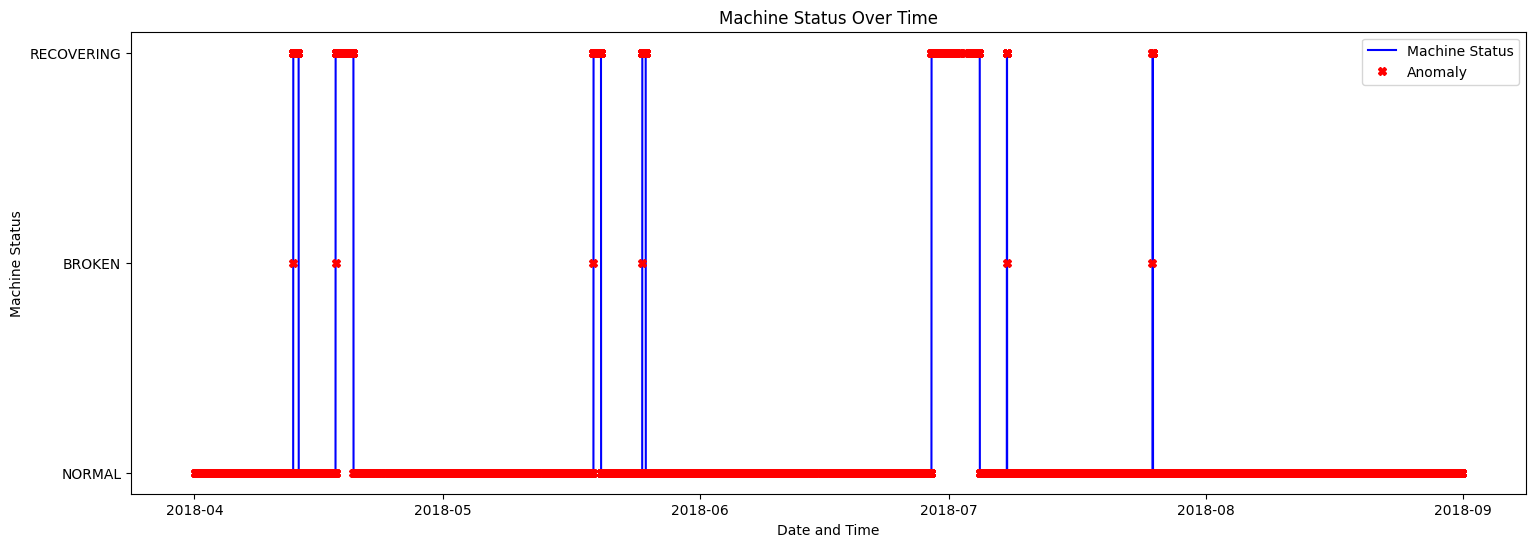

In [134]:
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
_ = plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Machine Status')
_ = plt.title('Machine Status Over Time')
_ = plt.legend(loc='best')
plt.show()

In [135]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Add the anomaly results to the anomaly DataFrame
anomaly_df.loc[1, 'Normal'] = len(df) - num_anomalies
anomaly_df.loc[1, 'Anomalies'] = num_anomalies
anomaly_df.loc[1, 'Percentage'] = percentage_anomalies
anomaly_df

Number of anomalies detected: 10871
Percentage of anomalies detected: 4.93%


,Method,Normal,Anomalies,Percentage
0,IQR,170479,49841,22.620000
1,K-Means,209449,10871,4.934187
2,HST,0,0,0.000000


Finally, we summarize the anomalies detected by the K-Means method, providing a count of the number of anomalies detected.
- Number of anomalies detected: 22,032
- Percentage of anomalies: 10%

## Half-Space Trees (HST)

Half-Space Trees (HST) is an anomaly detection algorithm designed for data streams. It works by partitioning the data space into smaller regions using random hyperplanes. Each tree in the ensemble represents a hierarchical partitioning of the data space.   

The anomaly score of a data point is determined by how deeply it is required to traverse the tree structure before it is isolated. Points that are isolated closer to the root are considered more anomalous.

In [136]:
from river import anomaly
from river import preprocessing

# Reset the anomaly column
pca_df['anomaly'] = False

# Initialize the standard scaler
scaler = preprocessing.StandardScaler()

# Initialize the Half-Space Trees anomaly detector
hst = anomaly.HalfSpaceTrees(n_trees=15)

anomalies_count = 0

# Anomaly threshold
anomaly_threshold = 0.98 

for i, row in pca_df.iterrows():
    data_point = {col: row[col] for col in ['PC1', 'PC2']}
    
    # Update the scaler with the new data point
    scaler.learn_one(data_point)
    data_point = scaler.transform_one(data_point)
    
    if hst.n_trees > 0:
        # Obtain the anomaly score from HST for the current point
        anomaly_score = hst.score_one(data_point)
    else:
        anomaly_score = 0
    
    # Update the HST with the new data point
    hst.learn_one(data_point)

    # If the anomaly score is greater than the threshold, mark as anomaly
    if anomaly_score > anomaly_threshold:
        anomalies_count += 1
        pca_df.loc[i, 'anomaly'] = True

print(f"Number of anomalies detected using Half-Space Trees: {anomalies_count}")

Number of anomalies detected using Half-Space Trees: 9756


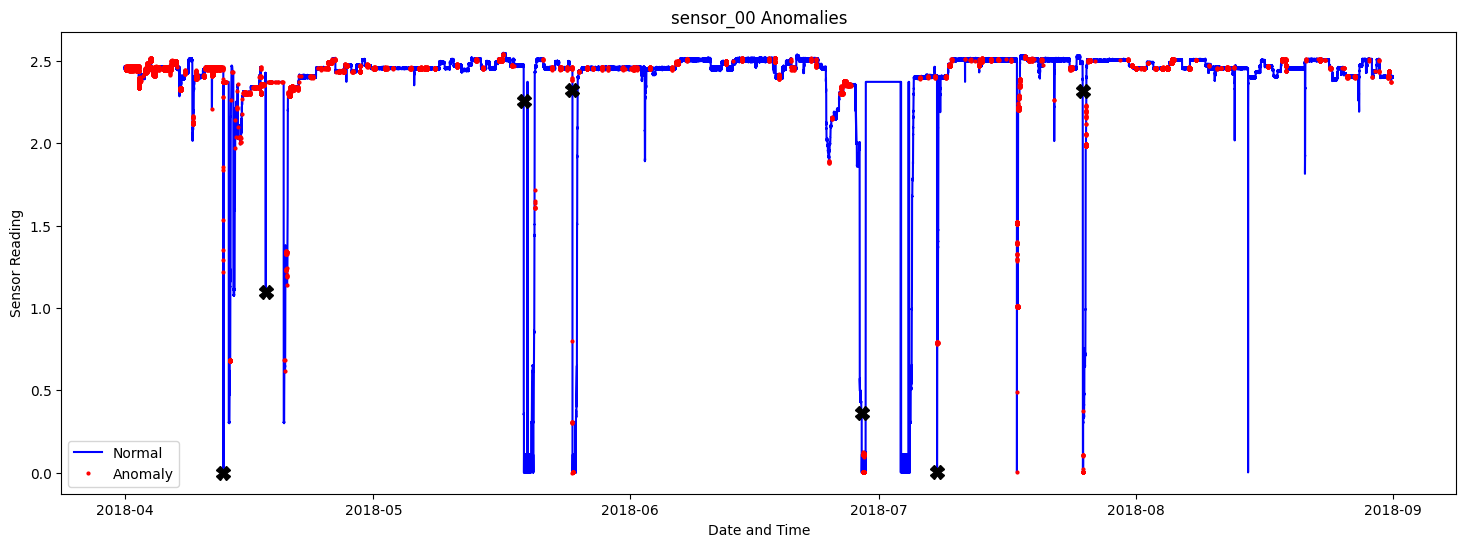

In [137]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[sensor], color='blue', label='Normal')
_ = plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
_ = plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'{sensor} Anomalies')
_ = plt.legend(loc='best')
plt.show()

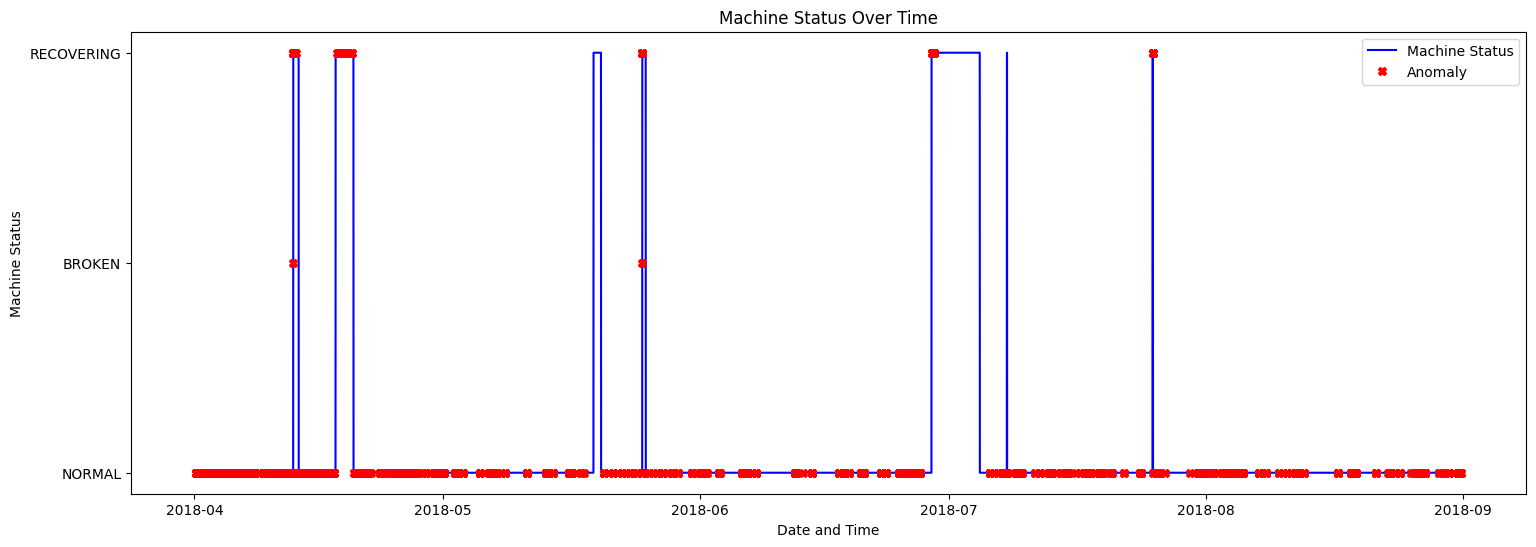

In [138]:
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
_ = plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Machine Status')
_ = plt.title('Machine Status Over Time')
_ = plt.legend(loc='best')
plt.show()

In [139]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Add the anomaly results to the anomaly DataFrame
anomaly_df.loc[2, 'Normal'] = len(df) - num_anomalies
anomaly_df.loc[2, 'Anomalies'] = num_anomalies
anomaly_df.loc[2, 'Percentage'] = percentage_anomalies
anomaly_df

Number of anomalies detected: 9756
Percentage of anomalies detected: 4.43%


,Method,Normal,Anomalies,Percentage
0,IQR,170479,49841,22.620000
1,K-Means,209449,10871,4.934187
2,HST,210564,9756,4.428105


## Final Conclusions

Incremental anomaly detection methods offer a significant advantage in scenarios involving continuous or real-time data streams, as they allow for efficient model updates without the need for complete retraining. This adaptability makes them particularly valuable in dynamic environments where data patterns evolve over time.   

However, a notable drawback of these approaches is that, due to their lack of access to the full dataset from the beginning, they often tend to identify anomalies that are less coherent or statistically meaningful. In other words, while these methods are efficient and adaptive, their detection accuracy and consistency may suffer from the absence of a solid baseline.   

To address this, we think that the best approach would be a hybrid strategy in which a non-incremental method is applied initially to a representative subset of historical data. This preliminary phase allows for the construction of a more robust reference model and the establishment of reliable anomaly thresholds or patterns. Once this initial analysis is complete, the process can transition to the use of incremental methods like Half-Space Trees to continue anomaly detection in real time, thus leveraging the adaptability of incremental algorithms without compromising the coherence and quality of the results.